In [314]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [315]:
train_raw = pd.read_csv('../data/processed/train.csv') #学習データ
test_raw = pd.read_csv('../data/processed/test.csv') #テストデータ
print('The size of the train data:' + str(train_raw.shape))
print('The size of the test data:' + str(test_raw.shape))

The size of the train data:(891, 12)
The size of the test data:(418, 11)


In [316]:
train_mid = train_raw.copy()
test_mid = test_raw.copy()
train_mid['train_or_test'] = 'Train' #学習データフラグ
test_mid['train_or_test'] = 'Test' #テストデータフラグ
test_mid['Survived'] = 9 #テストにSurvivedカラムを仮置き

alldata = pd.concat(
    [
        train_mid,
        test_mid
    ],
    sort=False,
    axis=0
).reset_index(drop=True)

In [317]:
print(alldata.shape)
alldata.head()

(1309, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_or_test
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Train
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Train
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Train
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Train


In [318]:
alldata.Ticket.map(lambda x: x[1]).value_counts()

4    234
1    194
6    174
C    118
.    103
3    102
5     74
7     57
9     52
8     38
/     35
2     31
O     28
T     22
A     22
       8
P      5
I      4
Q      2
0      2
E      2
W      1
a      1
Name: Ticket, dtype: int64

In [319]:
# テストデータの敬称(honorific)を抽出
alldata['honorific'] = alldata['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])

In [320]:
# Ageを補完
for i,v in alldata.groupby(['honorific']):
    if v.Age.isnull().sum() > 0:
        alldata.loc[(alldata.honorific==i) & alldata.Age.isnull(), 'Age'] = v.Age.mean()

In [321]:
# Embarkedには最頻値を代入
alldata.Embarked.fillna(alldata.Embarked.mode()[0], inplace=True)
# Fareには中央値を代入
alldata.Fare.fillna(alldata.Fare.median(), inplace=True)

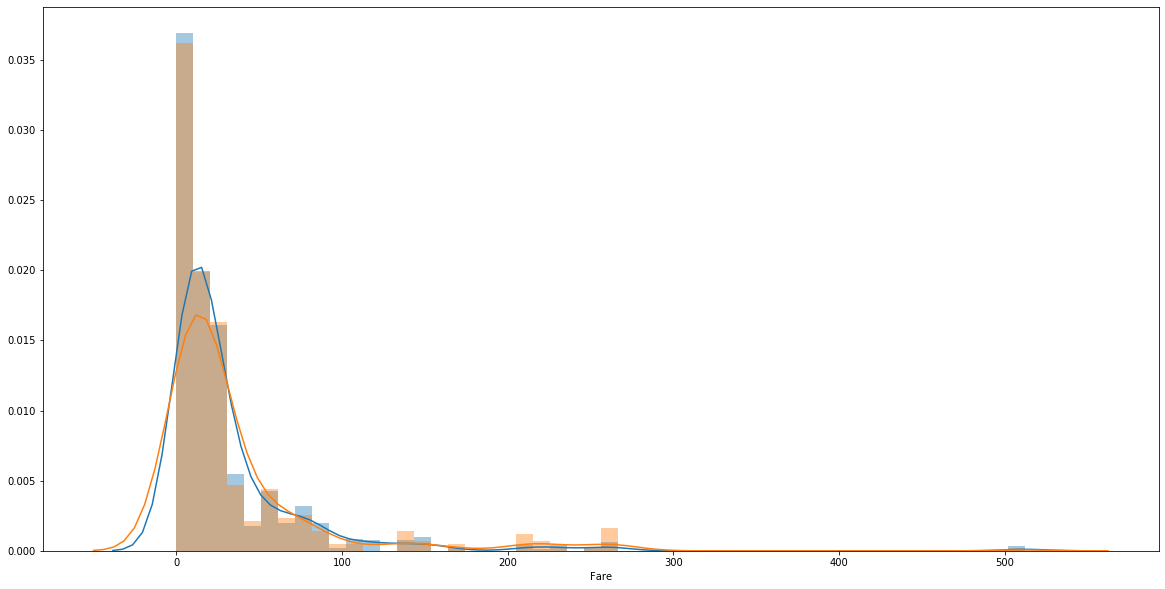

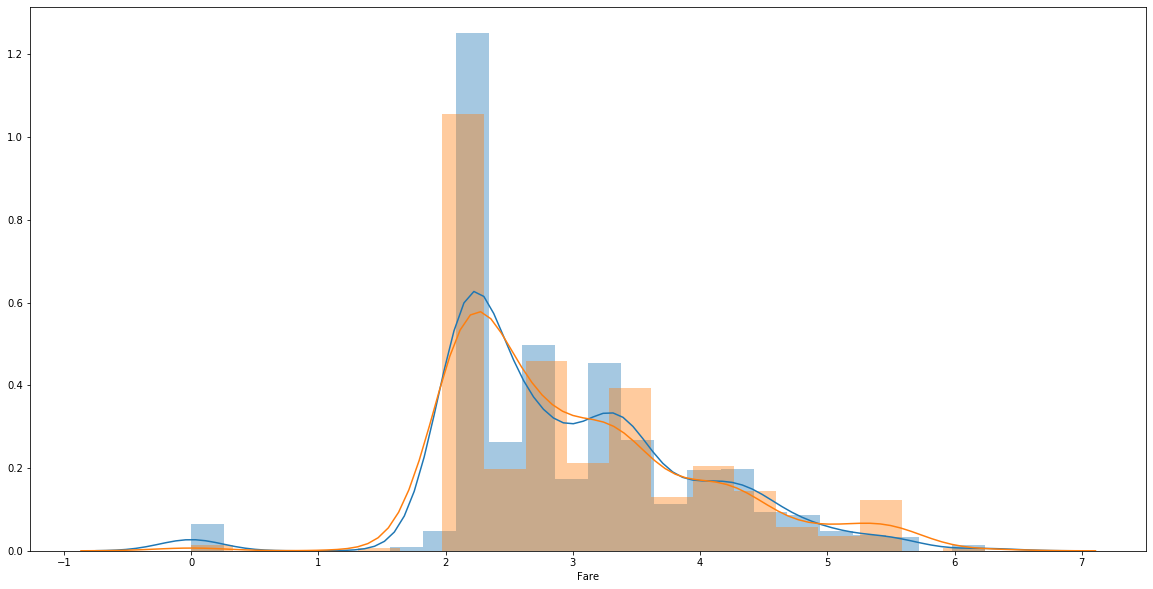

In [322]:
# Fareを対数変換した後のプロット
plt.figure(figsize=(20,10))
sns.distplot(alldata.query('train_or_test == "Train"').Fare)
sns.distplot(alldata.query('train_or_test == "Test"').Fare)
plt.figure(figsize=(20,10))
sns.distplot(np.log1p(alldata.query('train_or_test == "Train"').Fare))
sns.distplot(np.log1p(alldata.query('train_or_test == "Test"').Fare))

In [323]:
alldata.loc[:, 'Fare_log'] = np.log1p(alldata.Fare)

# print(alldata.query('Fare_log < 2 & train_or_test == "Train"').Survived.sum()/len(alldata.query('Fare_log < 2 & train_or_test == "Train"')))
# print(alldata.query('Fare_log > 4 & train_or_test == "Train"').Survived.sum()/len(alldata.query('Fare_log > 4 & train_or_test == "Train"')))
# print(alldata.query('4 >= Fare_log >= 2 & train_or_test == "Train"').Survived.sum()/len(alldata.query('4 >= Fare_log >= 2 & train_or_test == "Train"')))

In [324]:
# Fareの分割
# alldata['Fare_bin'] = 'low'
# alldata.loc[alldata['Fare_log']>4, 'Fare_bin'] = 'high'
# alldata.loc[(alldata['Fare']>=2) & (alldata['Fare']<=4), 'Fare_bin'] = 'middle'
# 敬称(honorific)の加工
alldata['honorific'].replace(['Col','Dr', 'Rev'], 'Rare',inplace=True) #少数派の敬称を統合
alldata['honorific'].replace('Mlle', 'Miss',inplace=True) #Missに統合
alldata['honorific'].replace('Ms', 'Miss',inplace=True) #Missに統合
# Familysize
alldata['FamilySize'] = alldata['Parch'] + alldata['SibSp'] #ALLデータ
# FamilySizeを離散化
# alldata['FamilySize_bin'] = 'big'
# alldata.loc[alldata['FamilySize']==1,'FamilySize_bin'] = 'alone'
# alldata.loc[(alldata['FamilySize']>=2) & (alldata['FamilySize']<=4),'FamilySize_bin'] = 'small'
# alldata.loc[(alldata['FamilySize']>=5) & (alldata['FamilySize']<=7),'FamilySize_bin'] = 'mediam'
# Cabinの頭文字
alldata['Cabin_ini'] = alldata['Cabin'].map(lambda x:str(x)[0])
alldata['Cabin_ini'].replace(['G','T'], 'Rare',inplace=True) #少数派のCabin_iniを統合

In [325]:
id_col = 'PassengerId'
target_col = 'Survived'
# feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Fare_bin', 'Embarked','honorific', 'FamilySize', 'FamilySize_bin', 'Cabin_ini']
# feature_cols = ['Pclass', 'Sex', 'SibSp', 'Fare_bin', 'Embarked','honorific', 'FamilySize_bin', 'Cabin_ini']
drop_col = ['PassengerId','Survived', 'Name', 'Fare', 'Ticket', 'Cabin', 'train_or_test', 'Age', 'Parch']

In [326]:
# Pclassをオブジェクト型に変換
alldata.Pclass = alldata.Pclass.astype('str')

In [327]:
# カテゴリカル変数
# cat_col = ['Pclass','Sex','Embarked','honorific','Fare_bin','FamilySize_bin','Cabin_ini']
cat_col = ['Pclass','Sex','Embarked','honorific','Cabin_ini']

In [328]:
# 欠損値補完
alldata.isnull().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin            1014
Embarked            0
train_or_test       0
honorific           0
Fare_log            0
FamilySize          0
Cabin_ini           0
dtype: int64

In [329]:
# # カテゴリ特徴量についてラベルエンコーディング
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# for col in object_cols:
#     alldata.loc[:, col] = le.fit_transform(alldata[col])

In [330]:
alldata = pd.get_dummies(alldata, drop_first=True, columns=cat_col)

In [331]:
alldata.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'train_or_test', 'Fare_log', 'FamilySize', 'Pclass_2',
       'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'honorific_Don',
       'honorific_Dona', 'honorific_Jonkheer', 'honorific_Lady',
       'honorific_Major', 'honorific_Master', 'honorific_Miss',
       'honorific_Mme', 'honorific_Mr', 'honorific_Mrs', 'honorific_Rare',
       'honorific_Sir', 'honorific_the Countess', 'Cabin_ini_B', 'Cabin_ini_C',
       'Cabin_ini_D', 'Cabin_ini_E', 'Cabin_ini_F', 'Cabin_ini_Rare',
       'Cabin_ini_n'],
      dtype='object')

In [332]:
train = alldata.query('train_or_test == "Train"')
test = alldata.query('train_or_test == "Test"')

In [333]:
from sklearn.model_selection import train_test_split

In [334]:
train_feature = train.drop(columns=drop_col)
test_feature = test.drop(columns=drop_col)
train_tagert = train[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    train_feature, train_tagert, test_size=0.2, random_state=0, stratify=train_tagert)

In [335]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## ベースライン

In [336]:
survive_rate = y_train.sum()/len(y_train)
print(f'survive rate:{survive_rate}')

survive rate:0.38342696629213485


In [337]:
print(f'base line accuracy: {1 - survive_rate}')

base line accuracy: 0.6165730337078652


In [338]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
print('RandomForestClassifier')
print('='*20)
print(f'accuracy of train set: {rfc.score(X_train, y_train)}')
print(f'accuracy of test set: {rfc.score(X_test, y_test)}')

RandomForestClassifier
accuracy of train set: 0.9424157303370787
accuracy of test set: 0.7988826815642458


In [339]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)
print('XGBClassifier')
print('='*20)
print(f'accuracy of train set: {xgb.score(X_train, y_train)}')
print(f'accuracy of train set: {xgb.score(X_test, y_test)}')

XGBClassifier
accuracy of train set: 0.8862359550561798
accuracy of train set: 0.8379888268156425


In [340]:
lgb = LGBMClassifier(random_state=0)
lgb.fit(X_train, y_train)
print('LGBMClassifier')
print('='*20)
print(f'accuracy of train set: {lgb.score(X_train, y_train)}')
print(f'accuracy of train set: {lgb.score(X_test, y_test)}')

LGBMClassifier
accuracy of train set: 0.901685393258427
accuracy of train set: 0.8324022346368715


In [341]:
svc = SVC(random_state=0)
svc.fit(X_train, y_train)
print('SVC')
print('='*20)
print(f'accuracy of train set: {svc.score(X_train, y_train)}')
print(f'accuracy of train set: {svc.score(X_test, y_test)}')

SVC
accuracy of train set: 0.8384831460674157
accuracy of train set: 0.8100558659217877


In [342]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
print('LogisticRegression')
print('='*20)
print(f'accuracy of train set: {lr.score(X_train, y_train)}')
print(f'accuracy of train set: {lr.score(X_test, y_test)}')

LogisticRegression
accuracy of train set: 0.8300561797752809
accuracy of train set: 0.8156424581005587


In [343]:
import matplotlib.pyplot as plt

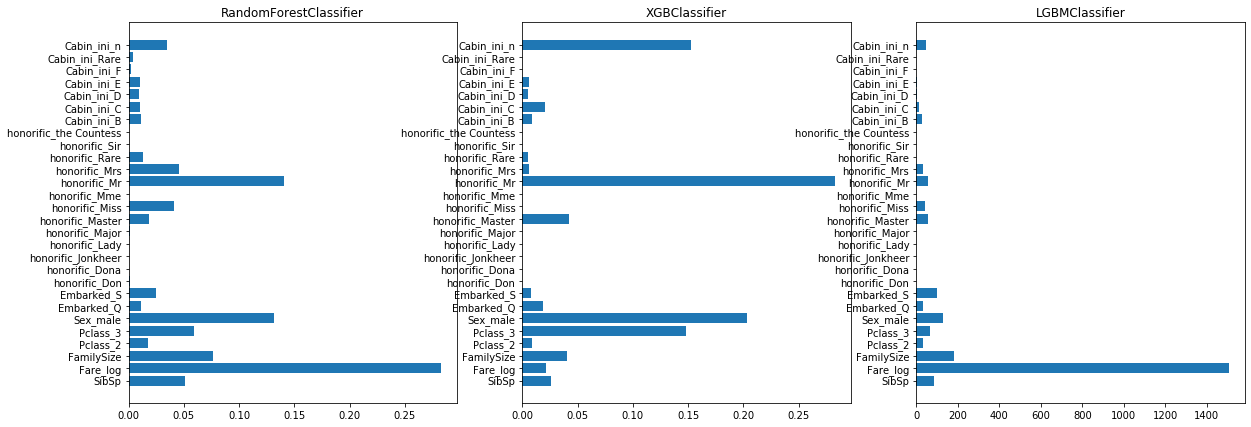

In [344]:
model_dict = {'RandomForestClassifier': rfc, 'XGBClassifier': xgb, 'LGBMClassifier': lgb}
plt.figure(figsize=(20,7))
i = 1
for model_nm, model in model_dict.items():
    plt.subplot(1,3,i)
    plt.barh(X_train.columns, model.feature_importances_, label=model_nm)
    plt.title(model_nm)
    i += 1

<BarContainer object of 28 artists>

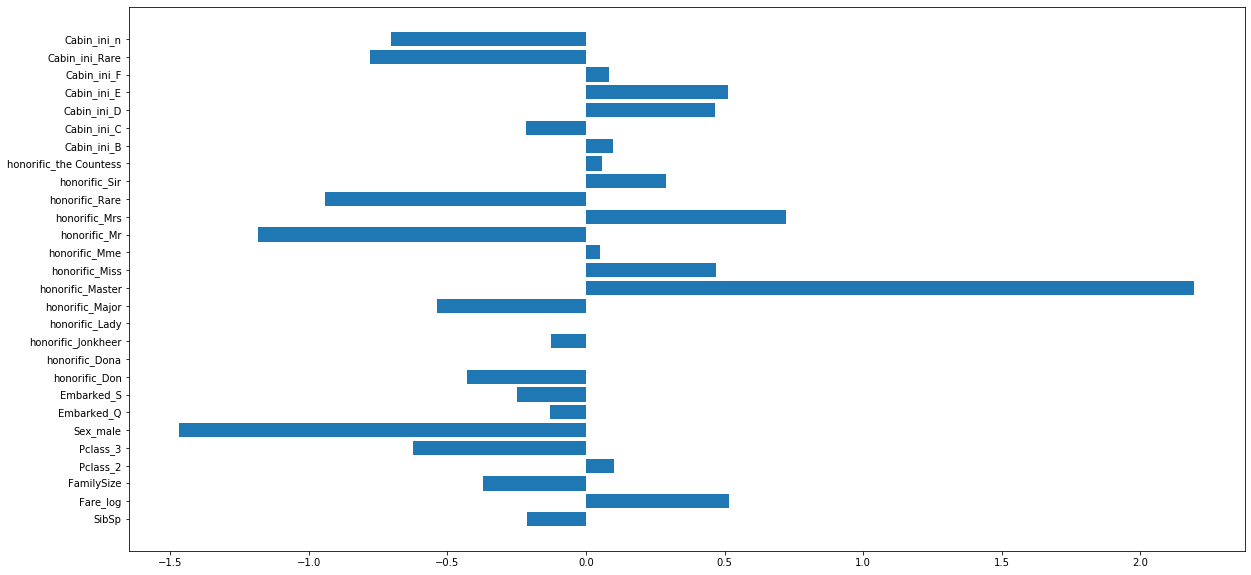

In [345]:
import numpy as np
plt.figure(figsize=(20,10))
plt.barh(np.array(X_train.columns),lr.coef_[0])

# 特徴量選択

In [347]:
# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(random_state=0)
# lr.fit(X_train, y_train)
# print('LogisticRegression')
# print('='*20)
# print(f'accuracy of train set: {lr.score(X_train, y_train)}')
# print(f'accuracy of train set: {lr.score(X_test, y_test)}')

## パラメータチューニング

In [348]:
from sklearn.model_selection import StratifiedKFold, cross_validate

In [349]:
import optuna

In [350]:
cv = 5

In [351]:
def objective(trial):
    # "n_estimators":trial.suggest_int("n_estimators", 50, 200),
    #
    param_grid_rfc = {
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 0
    }

    model = RandomForestClassifier(**param_grid_rfc)
    
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # 最小化なので 1.0 からスコアを引く
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_params)
print(study.best_value)
rfc_best_param = study.best_params

[I 2020-01-18 07:36:24,149] Finished trial#0 resulted in value: 0.8300600807643062. Current best value is 0.8300600807643062 with parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'criterion': 'gini'}.
[I 2020-01-18 07:36:25,675] Finished trial#1 resulted in value: 0.8328474342558849. Current best value is 0.8328474342558849 with parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}.
[I 2020-01-18 07:36:26,825] Finished trial#2 resulted in value: 0.825844577957254. Current best value is 0.8328474342558849 with parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}.
[I 2020-01-18 07:36:27,972] Finished trial#3 resulted in value: 0.8272628779671033. Current best value is 0.8328474342558849 with parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}.
[I 2020-01-18 07:36:29,092] Finished trial#4 resulted in value: 0.8286516300600807. Current best value is 0.8328474342558849 with parameters: {'max_depth': 8, 'min_samples_leaf

{'max_depth': 9, 'min_samples_leaf': 2, 'criterion': 'gini'}
0.837092484979809


In [352]:
def objective(trial):
    
    param_grid_xgb = {
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 5),
        'gamma': trial.suggest_discrete_uniform("gamma", 0.1, 1.0, 0.1),
        'subsample': trial.suggest_discrete_uniform("subsample", 0.5, 1.0, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform("colsample_bytree", 0.5, 1.0, 0.1),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        "random_state": 0
    }

    model = XGBClassifier(**param_grid_xgb)
    
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # 最小化なので 1.0 からスコアを引く
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_params)
print(study.best_value)
xgb_best_param = study.best_params

[I 2020-01-18 07:37:57,224] Finished trial#0 resulted in value: 0.8314783807741554. Current best value is 0.8314783807741554 with parameters: {'min_child_weight': 2, 'gamma': 0.8, 'subsample': 0.6, 'colsample_bytree': 0.9, 'max_depth': 3}.
[I 2020-01-18 07:37:57,636] Finished trial#1 resulted in value: 0.8244558258642766. Current best value is 0.8314783807741554 with parameters: {'min_child_weight': 2, 'gamma': 0.8, 'subsample': 0.6, 'colsample_bytree': 0.9, 'max_depth': 3}.
[I 2020-01-18 07:37:58,078] Finished trial#2 resulted in value: 0.8286713286713286. Current best value is 0.8314783807741554 with parameters: {'min_child_weight': 2, 'gamma': 0.8, 'subsample': 0.6, 'colsample_bytree': 0.9, 'max_depth': 3}.
[I 2020-01-18 07:37:58,688] Finished trial#3 resulted in value: 0.8272333300502315. Current best value is 0.8314783807741554 with parameters: {'min_child_weight': 2, 'gamma': 0.8, 'subsample': 0.6, 'colsample_bytree': 0.9, 'max_depth': 3}.
[I 2020-01-18 07:37:59,241] Finished tri

{'min_child_weight': 2, 'gamma': 0.30000000000000004, 'subsample': 0.5, 'colsample_bytree': 1.0, 'max_depth': 5}
0.8426868905742145


In [353]:
def objective(trial):
    
    param_grid_lgb = {
        'num_leaves': trial.suggest_int("num_leaves", 3, 10),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1.0),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        "random_state": 0
    }

    model = LGBMClassifier(**param_grid_lgb)
    
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # 最小化なので 1.0 からスコアを引く
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_params)
print(study.best_value)
lgb_best_param = study.best_params

[I 2020-01-18 07:38:43,974] Finished trial#0 resulted in value: 0.749995075347188. Current best value is 0.749995075347188 with parameters: {'num_leaves': 5, 'learning_rate': 0.0027275289693207343, 'max_depth': 4}.
[I 2020-01-18 07:38:44,232] Finished trial#1 resulted in value: 0.6165763813651137. Current best value is 0.749995075347188 with parameters: {'num_leaves': 5, 'learning_rate': 0.0027275289693207343, 'max_depth': 4}.
[I 2020-01-18 07:38:44,530] Finished trial#2 resulted in value: 0.6165763813651137. Current best value is 0.749995075347188 with parameters: {'num_leaves': 5, 'learning_rate': 0.0027275289693207343, 'max_depth': 4}.
[I 2020-01-18 07:38:44,838] Finished trial#3 resulted in value: 0.8356840342755836. Current best value is 0.8356840342755836 with parameters: {'num_leaves': 10, 'learning_rate': 0.07089825894630716, 'max_depth': 7}.
[I 2020-01-18 07:38:45,124] Finished trial#4 resulted in value: 0.8272727272727274. Current best value is 0.8356840342755836 with paramet

{'num_leaves': 6, 'learning_rate': 0.1778995181251207, 'max_depth': 8}
0.8399093863882596


In [354]:
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    
    param_grid_lr = {
        'C' : trial.suggest_int("C", 1, 100),
        "random_state": 0
    }

    model = LogisticRegression(**param_grid_lr)
    
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # 最小化なので 1.0 からスコアを引く
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(study.best_params)
print(study.best_value)
lr_best_param = study.best_params

[I 2020-01-18 07:39:13,706] Finished trial#0 resulted in value: 0.8188712695754949. Current best value is 0.8188712695754949 with parameters: {'C': 89}.
[I 2020-01-18 07:39:14,275] Finished trial#1 resulted in value: 0.823086772382547. Current best value is 0.823086772382547 with parameters: {'C': 97}.
[I 2020-01-18 07:39:14,788] Finished trial#2 resulted in value: 0.8202797202797203. Current best value is 0.823086772382547 with parameters: {'C': 97}.
[I 2020-01-18 07:39:15,364] Finished trial#3 resulted in value: 0.823086772382547. Current best value is 0.823086772382547 with parameters: {'C': 97}.
[I 2020-01-18 07:39:15,847] Finished trial#4 resulted in value: 0.8216783216783217. Current best value is 0.823086772382547 with parameters: {'C': 97}.
[I 2020-01-18 07:39:16,324] Finished trial#5 resulted in value: 0.8202698709740963. Current best value is 0.823086772382547 with parameters: {'C': 97}.
[I 2020-01-18 07:39:16,861] Finished trial#6 resulted in value: 0.8188712695754949. Curre

{'C': 97}
0.823086772382547


In [355]:
# param_grid_svc = {'C': [50, 100, 150], 'gamma': [0.0001, 0.0005, 0.0007], 'kernel': ['rbf']}

# svc_grid = GridSearchCV(
#     estimator=SVC(random_state=0),
#     param_grid=param_grid_svc,   
#     scoring="accuracy",
#     cv=cv,
#     n_jobs=4
# )

# svc_grid.fit(X_train, y_train)

# print(f'best param:{svc_grid.best_params_}')
# print(f'test score:{svc_grid.score(X_test, y_test)}')

### 再学習

In [356]:
# 5-Fold CV / Accuracy でモデルを評価する
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [357]:
rfc_best = RandomForestClassifier(**rfc_best_param)
print('RandomForestClassifier')
print('='*20)
scores = cross_validate(rfc_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)
xgb_best = XGBClassifier(**xgb_best_param)
print('XGBClassifier')
print('='*20)
scores = cross_validate(xgb_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)
lgb_best = LGBMClassifier(**lgb_best_param)
print('LGBMClassifier')
print('='*20)
scores = cross_validate(lgb_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)
lr_best = LogisticRegression(**lr_best_param)
print('LogisticRegression')
print('='*20)
scores = cross_validate(lr_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
# print('='*20)
# svc_best = SVC(**lr_best_param)
# svc_best.fit(X_train, y_train)
# print('SVC')
# print('='*20)
# print(svc_best.score(X_train, y_train))
# print(svc_best.score(X_test, y_test))

RandomForestClassifier
mean:0.8293704098926622, std:0.0211289714791781
XGBClassifier
mean:0.8170547988199109, std:0.009872336337193846
LGBMClassifier
mean:0.8181721172556651, std:0.006975759450561742
LogisticRegression
mean:0.8158935408951102, std:0.030022536812084617


In [358]:
import numpy as np

def average_model(
    models:list,
    ge:int,
    train:pd.DataFrame,
    test:pd.Series=None
):
    
    sum_pred = 0
    for model in models:
        sum_pred += model.predict(train)
    sum_pred = np.where(sum_pred >= ge, 1, 0)
    if test is not None:
        print(f'accuracy{(sum_pred == np.array(test)).sum()/len(train)}')
    
    return sum_pred

# 推論

In [359]:
rfc_best = RandomForestClassifier(**rfc_best_param)
rfc_best.fit(train_feature, train_tagert)

xgb_best = XGBClassifier(**xgb_best_param)
xgb_best.fit(train_feature, train_tagert)

lgb_best = LGBMClassifier(**lgb_best_param)
lgb_best.fit(train_feature, train_tagert)

lr_best = LogisticRegression(**lr_best_param)
lr_best.fit(train_feature, train_tagert)

# svc_best = SVC(**svc_best_param)
# svc_best.fit(train_feature, train_tagert)

LogisticRegression(C=97, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [360]:
# pred = average_model([rfc_best,xgb_best,lgb_best], test_feature)
# pred = svc_best.predict(test_feature)
pred_rfc = rfc_best.predict(test_feature)
pred_xgb = xgb_best.predict(test_feature)
pred_lgb = lgb_best.predict(test_feature)
pred_lr = lr_best.predict(test_feature)
# pred = average_model(
#     [rfc_best,xgb_best,lgb_best,lr_best,svc_best],
#     3,
#     test_feature
# )
# pred = average_model([rfc,xgb,lgb], test_feature)
# pred = lr.predict(test_feature)

In [302]:
pd.concat(
    [
        pd.DataFrame(test.PassengerId, columns=['PassengerId']).reset_index(drop=True),
        pd.DataFrame(pred_rfc, columns=['Survived'])
    ],
    axis=1
).to_csv('output_rfc.csv', index=False)

pd.concat(
    [
        pd.DataFrame(test.PassengerId, columns=['PassengerId']).reset_index(drop=True),
        pd.DataFrame(pred_xgb, columns=['Survived'])
    ],
    axis=1
).to_csv('output_xgb.csv', index=False)

pd.concat(
    [
        pd.DataFrame(test.PassengerId, columns=['PassengerId']).reset_index(drop=True),
        pd.DataFrame(pred_lgb, columns=['Survived'])
    ],
    axis=1
).to_csv('output_lgb.csv', index=False)

pd.concat(
    [
        pd.DataFrame(test.PassengerId, columns=['PassengerId']).reset_index(drop=True),
        pd.DataFrame(pred_lr, columns=['Survived'])
    ],
    axis=1
).to_csv('output_lr.csv', index=False)

In [194]:
a = pd.read_csv('output.csv')
b = pd.read_csv('output_1.csv')
c = pd.read_csv('output_2.csv')

In [195]:
(a==c).sum()

PassengerId    418
Survived       389
dtype: int64

In [53]:
test

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,FamilySize_bin_big,FamilySize_bin_mediam,FamilySize_bin_small,Cabin_ini_B,Cabin_ini_C,Cabin_ini_D,Cabin_ini_E,Cabin_ini_F,Cabin_ini_Rare,Cabin_ini_n
891,892,9,3,"Kelly, Mr. James",34.500000,0,0,330911,7.8292,NaN,...,0,0,0,0,0,0,0,0,0,1
892,893,9,3,"Wilkes, Mrs. James (Ellen Needs)",47.000000,1,0,363272,7.0000,NaN,...,0,0,1,0,0,0,0,0,0,1
893,894,9,2,"Myles, Mr. Thomas Francis",62.000000,0,0,240276,9.6875,NaN,...,0,0,0,0,0,0,0,0,0,1
894,895,9,3,"Wirz, Mr. Albert",27.000000,0,0,315154,8.6625,NaN,...,0,0,0,0,0,0,0,0,0,1
895,896,9,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.000000,1,1,3101298,12.2875,NaN,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,9,3,"Spector, Mr. Woolf",32.252151,0,0,A.5. 3236,8.0500,NaN,...,0,0,0,0,0,0,0,0,0,1
1305,1306,9,1,"Oliva y Ocana, Dona. Fermina",39.000000,0,0,PC 17758,108.9000,C105,...,0,0,0,0,1,0,0,0,0,0
1306,1307,9,3,"Saether, Mr. Simon Sivertsen",38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,0,0,0,0,0,0,0,0,0,1
1307,1308,9,3,"Ware, Mr. Frederick",32.252151,0,0,359309,8.0500,NaN,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_feature = train[feature_cols]
train_tagert = train[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    train_feature, train_tagert, test_size=0.2, random_state=0, stratify=train_tagert)